## CAPSTONE PROJECT: ISSY LES MOULINEAUX

This Notebook is related to code only.
The report will be written as a PDF file, only when the code is finished.
Please do not pay attention to the lack of explanation here.

Imports to make the code run

In [1]:
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.0.1               |             py_0         575 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    openssl-1.1.1e             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.11.28         |   py36h9f0ad1d_1         149 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------------------------------------------
                       

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import math

In [17]:
import folium # map rendering library
import requests # library to handle requests
from sklearn.cluster import KMeans

### 1) Introduction (where you discuss the business problem and who would be interested in this project.)


#### Business problem



After looking at open data available, it seems, that some of the 'open' data are not so open.
This portion will be explained in the report, as this is not directly related to code.


 - <u>Problem definition:</u> Where are the best places to go in ISSY LES MOULINEAUX?


 - <u>Stakeholder</u>: The people interested in this project are business travalers, which are looking for a description and an objective overview of the city.


#### Data where you describe the data that will be used to solve the problem and the source of the data.



Sources of data are:<br>
- Foursquare: List of POI (points of interest)<br>
  Data are related to POI and each POI has a list of comments related to each of them.<br>
- Open Data from Issy-Les-Moulineaux city hall: https://data.iledefrance.fr/explore/dataset/points-dinteret-de-la-ville-dissy-les-moulineaux/table/<br>
  Data available here are linked to all activities related to this city: Companies (>50 employees), restaurants, public transport, ...<br>


 Open Data from Issy-Les-Moulineaux

In [5]:
#let's import data hand have a look to the 5 firsts lines
opendata = pd.read_csv('https://data.iledefrance.fr/explore/dataset/points-dinteret-de-la-ville-dissy-les-moulineaux/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B',delimiter = ';')
opendata.head()                  

,Titre,Favoris,Catégorie1,Catégorie2,Catégorie3,Catégorie4,Description,Adresse,Codepostal,Ville,Téléphone,URL,Email,WGS84,Latitude,Longitude
0,Ben Yahia Birck,NaN,Vie pratique,"Commerces, consommation","Epiceries, supérettes et grande distribution",NaN,Du mardi au dimanche de 8h à minuit,"35, rue Ernest Renan",92130.0,Issy-les-Moulineaux,01 46 48 64 51,NaN,NaN,"48.826655,2.280579",48.826655,2.280579
1,Conteneur à verre Boulevard Galliéni,NaN,Vie pratique,"Environnement, cadre de vie",Conteneurs à verre,NaN,"Conteneur enterré, à l'angle de la Rue Hoche.",83 Boulevard Galliéni,92130.0,Issy-les-Moulineaux,NaN,NaN,NaN,"48.823029,2.267992",48.823029,2.267992
2,Autolib' boulevard Garibaldi,NaN,Vie pratique,Transports,Autolib',NaN,Emplacement en voirie,18 boulevard Garibaldi,92130.0,Issy-les-Moulineaux,NaN,www.autolib.eu/fr/,NaN,"48.8215502,2.2613183",48.821550,2.261318
3,Parking motos Rue Diderot,NaN,Vie pratique,Transports,Parkings deux roues,Emplacements motos,"Total de 4 places, côté pair à l'angle de la R...",Rue Diderot,92130.0,Issy-les-Moulineaux,NaN,NaN,NaN,"48.825063,2.27213",48.825063,2.272130
4,Parking vélos Place Jacques Madaule,NaN,Vie pratique,Transports,Parkings deux roues,Emplacements vélos,Total de 12 places,Place Jacques Madaule,92130.0,Issy-les-Moulineaux,NaN,NaN,NaN,"48.824084,2.260681",48.824084,2.260681


In [6]:
#List of available columns
opendata.columns

Index(['Titre', 'Favoris', 'Catégorie1', 'Catégorie2', 'Catégorie3',
       'Catégorie4', 'Description', 'Adresse', 'Codepostal', 'Ville',
       'Téléphone', 'URL', 'Email', 'WGS84', 'Latitude', 'Longitude'],
      dtype='object')

In [7]:
#Size of the imported data
opendata.shape

(1188, 16)

In [8]:
#List of all categories. Level 3 is detailed enough for our plan (Category4 is too detailed: kind of food, ...)
opendata[['Catégorie3','Titre']].groupby(['Catégorie3']).count().sort_values('Titre',ascending=False).head(n=10)

,Titre
Catégorie3,
Restauration-Bars-Tabacs,150
Parkings deux roues,125
Conteneurs à verre,63
Arbres remarquables,50
Bureaux de vote,46
Coiffeurs,32
Sculptures de métal,27
"Epiceries, supérettes et grande distribution",27
Agences immobilières,26


In [9]:
#Focus on restaurants, as restaurants will be the key factor for this study (to be explained in the report)
opendata_restaurants=opendata[opendata['Catégorie3']=='Restauration-Bars-Tabacs']
opendata_restaurants.head()

,Titre,Favoris,Catégorie1,Catégorie2,Catégorie3,Catégorie4,Description,Adresse,Codepostal,Ville,Téléphone,URL,Email,WGS84,Latitude,Longitude
14,La Maison du Tajine,NaN,Vie pratique,"Commerces, consommation",Restauration-Bars-Tabacs,Restaurants-Spécialités orientales,Ouvert tous les jours de 12h à 14h30 et de 19h...,"3 bis, rue Henri Mayer",92130.0,Issy-les-Moulineaux,01 46 62 63 02,NaN,NaN,"48.827864,2.275662",48.827864,2.275662
25,Snc Tabac Glab,NaN,Vie pratique,"Commerces, consommation",Restauration-Bars-Tabacs,Débits de tabac,"Tabac, loto, PMU, presse. Ouvert du lundi au s...","19, rue Jean-Pierre Timbaud",92130.0,Issy-les-Moulineaux,01 46 38 62 66,NaN,NaN,"48.819527,2.2499",48.819527,2.249900
39,Pizza Siciliana,NaN,Vie pratique,"Commerces, consommation",Restauration-Bars-Tabacs,Restaurants-Spécialités italiennes,Ouvert du lundi au samedi de 12h à à 14h30 et ...,"164, avenue de Verdun",92130.0,Issy-les-Moulineaux,01 46 38 08 66,NaN,NaN,"48.818296,2.251516",48.818296,2.251516
55,Issy Fast Burger,NaN,Vie pratique,"Commerces, consommation",Restauration-Bars-Tabacs,Restauration rapide-Sandwicherie-Livraison à d...,Ouvert 7j/7 de 11h à 22h,"2, avenue Jean Jaurès",92130.0,Issy-les-Moulineaux,01 46 38 58 11,NaN,NaN,"48.824028,2.273603",48.824028,2.273603
62,Dod,NaN,Vie pratique,"Commerces, consommation",Restauration-Bars-Tabacs,Restauration rapide-Sandwicherie-Livraison à d...,"Plats prêts à cuisiner, prêts à manger, épicie...","11, rue Rouget de Lisle",92130.0,Issy-les-Moulineaux,01 47 36 36 70,www.chez-dod.net,NaN,"48.829009,2.264559",48.829009,2.264559


Foursquare Data

Now lets play with Foursquare.
But keep in mind, that the free API is limited, and I did not pay the pro version.
Therefore I will limit the list to restaurants and bars only

In [10]:

CLIENT_ID = 'FM5DMW2Y4XRLA0EQCAM3VOH40WTS5GIAV5I130M2ROQULLOZ'
CLIENT_SECRET = 'Y3P44JL2XIMG2HIJXJCZXNQIQMDOKUNYWHJ1ISMSS3RWDBL3'
VERSION = '20180605'


In [11]:

#get 1500 relevant data 2km around the city.
#Not only in this city (because the neighbourhood is also important)

def getNearbyVenues(name, lat, lng, radius = 2000, LIMIT = 1500):
    venues_list=[]
    url = 'https://api.foursquare.com/v2/venues/search?categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format( \
            CLIENT_ID,  \
            CLIENT_SECRET, \
            VERSION, \
            lat,  \
            lng,  \
            radius, \
            LIMIT)


    results = requests.get(url).json()['response']
    
    for v in results['venues'] :
            venues_list.append([(v['name'],
                                 v['id'],
                                 v['location']['lat'],
                                 v['location']['lng'], 
                                 v['categories'][0]['name'])])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Venue',
                             'Venue Id',
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

#Call of the function
Issy_venues = getNearbyVenues(name = 'Issy les moulineaux',
                                 lat = opendata_restaurants['Latitude'].median(),
                                 lng = opendata_restaurants['Longitude'].median())




In [12]:
#Visual inspection of imported data
Issy_venues.head()

,Venue,Venue Id,Venue Latitude,Venue Longitude,Venue Category
0,Laura Traiteur,4b9e2041f964a52039cc36e3,48.826148,2.265917,Falafel Restaurant
1,Grains et Gourmandises,5d8de602a67bc00008d9ef5c,48.833960,2.295044,Bakery
2,Mama Shelter Paris West,5d3727455c9d4c00083efc5e,48.829334,2.292303,Restaurant
3,L'Aviation,4b45ce92f964a520921026e3,48.828139,2.273809,Bistro
4,Pret A Manger,528df00e11d22680e55aca74,48.829012,2.264271,Sandwich Place


In [23]:
Issy_venues.shape

(50, 5)

### 2) Methodology section


#### 2.1) Classification of POI: Short description of the city and its facilities.


##### 2.1.1) Count of Venues for each category


In [13]:
opendata.groupby(['Catégorie2'])[['Titre']].count().sort_values('Titre',ascending=False)

,Titre
Catégorie2,
"Commerces, consommation",473
Transports,173
"Environnement, cadre de vie",131
"Administrations, vie citoyenne et vie pratique",68
Culture et loisirs,59
Petite Enfance,54
Education,50
Santé,44
Entreprises TIC + de 50 salariés,35


##### 2.1.2) Map of Restaurants


In [14]:


map_venues = folium.Map(location=[48.828139 , 2.273809], zoom_start = 14)

for lat, lng, venue, cat in zip(opendata_restaurants['Latitude'],
                                opendata_restaurants['Longitude'],
                                opendata_restaurants['Titre'],
                                opendata_restaurants['Catégorie2']):
    label = '{}, {}'.format(venue, cat)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [lat, lng],
        popup = label).add_to(map_venues)

map_venues



##### 2.1.3) Finding the main attractive neighbourhood in this city. (KNN)
If we consider, that restaurants are located where the main activities are... then we can focus on restaurants to highlight attractiveness of neighbourhoods


#### 2.2) Classification of Comments: 


In [16]:
# import k-means from clustering stage
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import jaccard_similarity_score
# from sklearn.neighbors import KNeighborsClassifier


In [49]:
#opendata_restaurants.groupby(['Latitude','Longitude','Titre'])[['Titre']].count().sort_values('Titre',ascending=False)
#opendata_restaurants[['Latitude','Longitude','Titre']].groupby(['Latitude','Longitude','Titre']).count().sort_values('Titre',ascending=False)




In [18]:
opendata_restaurants[['Latitude','Longitude']].head()

,Latitude,Longitude
14,48.827864,2.275662
25,48.819527,2.249900
39,48.818296,2.251516
55,48.824028,2.273603
62,48.829009,2.264559


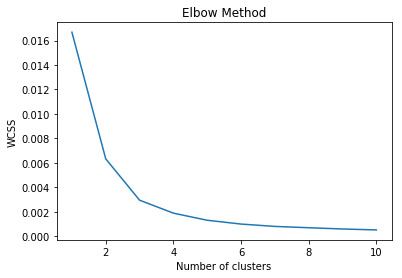

In [19]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(opendata_restaurants[['Latitude','Longitude']])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

The best number of K is 4: There are 4 main locations in this city, related to restaurants

In [21]:
print('In red are the KNN main locations')
map_clusters = folium.Map(location=[48.822664, 2.267804], zoom_start = 14)



kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit(opendata_restaurants[['Latitude','Longitude']])
pred_y = kmeans.fit_predict(opendata_restaurants[['Latitude','Longitude']])

for i in range(len(kmeans.cluster_centers_)):
    lat,lon=kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1]
    #print(i,[lat, lon])

    label = folium.Popup(' Cluster ' + str(i), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_clusters)


    
#map_clusters.save("doggie_clusters.html")    
map_clusters

In red are the KNN main locations


##### 2.2.1) Global overview of the whole city, and for all categories.
Now lets compare the KNN values found to the full dataset

In [25]:
map_clusters = folium.Map(location=[48.822664, 2.267804], zoom_start = 14)


#just add the full dataset to the same map
opendata_restaurants=opendata[opendata['Catégorie3']!='Restauration-Bars-Tabacs']

for lat, lon, poi, cluster in zip(opendata['Latitude'], opendata['Longitude'], opendata['Titre'], opendata['Catégorie2']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.3).add_to(map_clusters)

    
#just add the full dataset to the same map

for lat, lon, poi, cluster in zip(Issy_venues['Venue Latitude'], Issy_venues['Venue Longitude'], Issy_venues['Venue'], Issy_venues['Venue Category']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.3).add_to(map_clusters)

    
    
    
# redraw the red points to appear upper to others... (no added value here, except for a better appearance)
for i in range(len(kmeans.cluster_centers_)):
    lat,lon=kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1]
    #print(i,[lat, lon])

    label = folium.Popup(' Cluster ' + str(i), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_clusters)
    
#map_clusters.save("doggie_clusters.html")    
map_clusters


- Blue spots: Open Database from the french gourvernment
- Green spots: Foursquare data
- Red spots: Points of interest found by KNN using the restaurants declared in the open database



### 3) Results section (where you discuss the results)


Will be detailed in the report

### 4) Discussion section where you discuss any observations you noted and any recommendations you can make based on the results.


Will be detailed in the report



### 5) Conclusion section where you conclude the report.


Will be detailed in the report


----------END----------